In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import pickle
import collections
import glob
import json

import matplotlib.pyplot as plt
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Run times

Plot of run times

In [20]:
tool_to_domain = {'biobloom': 'nt', 
                  'blastn': 'nt', 
                  'bwa': 'nt', 
                  'bowtie2': 'nt',
                  'groot': 'nt',
                  'hmmsearch_nt': 'nt',
                  'blastp': 'aa', 
                  'blastx': 'nt_to_aa',
                  'paladin': 'nt_to_aa', 
                  'diamond_blastx': 'nt_to_aa', 
                  'diamond_blastp': 'aa',
                  'hmmsearch_aa': 'aa'}

tool_to_paradigm = {'biobloom': 'k-mer', 
                  'blastn': 'BLAST', 
                  'bwa': 'BWT', 
                  'bowtie2': 'BWT',
                  'groot': 'k-mer',
                  'hmmsearch_nt': 'HMM',
                  'blastp': 'BLAST', 
                  'blastx': 'BLAST',
                  'paladin': 'BWT', 
                  'diamond_blastx': 'BLAST', 
                  'diamond_blastp': 'BLAST',
                  'hmmsearch_aa': 'HMM'}



def read_timing(tsv_fp, tool_field, params):
    filepath = tsv_fp.split('/')
    
    domain = filepath[0]
    tool = filepath[tool_field]
    
    data = []
    with open(tsv_fp) as fh:
        for param, line in zip(params, fh):
            run_data = {}
            run_data['domain']  = domain
            run_data['tool'] = tool
            line = line.strip().split('\t')
            run_data['param'] = param
            run_data['time'] = float(line[1])
            run_data['memory'] = float(line[2])
            data.append(pd.Series(run_data))
    return pd.DataFrame(data)
        

hmmsearch_nt = read_timing('nt/hmmsearch_nt/time.tsv', 1, ['default'])    

biobloom = read_timing('nt/biobloom/time.tsv', 1, ['k5', 'k9', 'k15', 'k25'])
bwa = read_timing('nt/bwa/time.tsv', 1, ['default', 'low', 'high'])
bowtie2 = read_timing('nt/bowtie2/time.tsv', 1, ['very_fast', 'fast', 'default', 'very_sensitive',
                                                 'very_fast_local', 'fast_local', 'sensitive_local',
                                                'very_sensitive_local'])
blastn = read_timing('nt/blastn/time.tsv', 1, ['megablast', 'blastn'])
groot = read_timing('nt/groot/time.tsv', 1, ['card_k5_s64_j099', 'card_k5_s64_j090', 'card_k5_s128_j099', 
                                            'card_k5_s128_j090', 'card_k5_s256_j099', 'card_k5_s256_j090',
                                            'card_k7_s64_j099', 'card_k7_s128_j099', 'card_k7_s256_j099', 
                                            'card_k9_s64_j099', 'card_k9_s64_j090', 'card_k9_s128_j099',
                                            'card_k9_s256_j099', 'card_k9_s128_j090', 'card_k9_s256_j090'])

diamond_blastx = read_timing('nt_to_aa/diamond_blastx/time.tsv', 1, ['default', 'sensitive', 'more_sensitive'])
blastx = read_timing('nt_to_aa/blastx/time.tsv', 1, ['default'])
paladin = read_timing('nt_to_aa/paladin/time.tsv', 1, ['min5', 'default', 'min25'])

orfm = read_timing('aa/orfM/time.tsv', 1, ['min100'])
diamond_blastp = read_timing('aa/orfM/diamond_blastp/time.tsv', 2, ['default', 'sensitive', 'more_sensitive'])
blastp = read_timing('aa/orfM/blastp/time.tsv', 2, ['default'])
hmmsearch_aa = read_timing('aa/orfM/hmmsearch_aa/time.tsv', 
                          2, ['default'])


# orfm time must be added to diamond_blastp and blastp
# however as small
diamond_blastp['time']  = diamond_blastp['time'] + orfm.loc[0, 'time']
#diamond_blastp['memory'] < orfm.loc[0, 'memory']
blastp['time'] = blastp['time'] + orfm.loc[0, 'time']
hmmsearch_aa['time'] = hmmsearch_aa['time'] + orfm.loc[0, 'time']

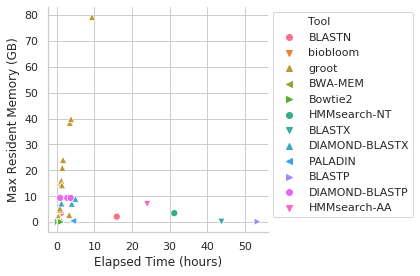

In [22]:
name_tidy = {'blastn': 'BLASTN', 'bwa': 'BWA-MEM', 'bowtie2': "Bowtie2", 'blastx': "BLASTX", 
             'diamond_blastx': "DIAMOND-BLASTX", 'paladin': "PALADIN", 'blastp': "BLASTP", 
             'diamond_blastp': "DIAMOND-BLASTP", 'hmmsearch_nt': 'HMMsearch-NT', 'hmmsearch_aa': 'HMMsearch-AA'}

timing = pd.concat([blastn, biobloom, groot, bwa, bowtie2, hmmsearch_nt, blastx, diamond_blastx, paladin, blastp, diamond_blastp, hmmsearch_aa])
timing['hours'] = timing['time'] / 60 / 60
timing['gb'] = timing['memory'] / 1024 / 1024
marker_list = ['o', 'v', '^', 
               '<', '>', 'o', 
               'v', '^', '<', 
               '>', 'o', 'v',
               '^', '<', '>']

timing['Paradigm'] = timing['tool'].apply(lambda x: tool_to_paradigm[x])
timing['tool'] = timing['tool'].replace(name_tidy)
sns.scatterplot(data = timing.rename(columns={'tool': 'Tool'}), 
                y='gb', x='hours', hue = 'Tool', markers = marker_list, style='Tool', s=50)
plt.ylabel('Max Resident Memory (GB)')
plt.xlabel('Elapsed Time (hours)')
plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
sns.despine()
#plt.savefig('figures/draft_figures/comp_comparison.svg')
#plt.savefig('figures/F1C_comp.pdf')
plt.savefig('figures/draft_figures/comp_comparison.png', dpi=300)

In [23]:
timing.sort_values('hours')

,domain,tool,param,time,memory,hours,gb,Paradigm
1,nt,Bowtie2,fast,938.67,26652.0,0.260742,0.025417,BWT
2,nt,Bowtie2,default,1001.67,29668.0,0.278242,0.028294,BWT
0,nt,Bowtie2,very_fast,1028.51,26780.0,0.285697,0.025539,BWT
9,nt,groot,card_k9_s64_j099,1393.32,2188932.0,0.387033,2.087528,k-mer
3,nt,biobloom,k25,1394.34,7780.0,0.387317,0.007420,k-mer
2,nt,biobloom,k15,1411.91,7716.0,0.392197,0.007359,k-mer
0,nt,groot,card_k5_s64_j099,1420.76,2602604.0,0.394656,2.482037,k-mer
3,nt,Bowtie2,very_sensitive,1443.34,36260.0,0.400928,0.034580,BWT
1,nt,biobloom,k9,1699.08,7312.0,0.471967,0.006973,k-mer
0,nt,biobloom,k5,1712.41,7196.0,0.475669,0.006863,k-mer


In [24]:
timing.sort_values('gb')

,domain,tool,param,time,memory,hours,gb,Paradigm
0,nt,biobloom,k5,1712.41,7196.0,0.475669,0.006863,k-mer
1,nt,biobloom,k9,1699.08,7312.0,0.471967,0.006973,k-mer
2,nt,biobloom,k15,1411.91,7716.0,0.392197,0.007359,k-mer
3,nt,biobloom,k25,1394.34,7780.0,0.387317,0.007420,k-mer
1,nt,Bowtie2,fast,938.67,26652.0,0.260742,0.025417,BWT
0,nt,Bowtie2,very_fast,1028.51,26780.0,0.285697,0.025539,BWT
2,nt,Bowtie2,default,1001.67,29668.0,0.278242,0.028294,BWT
4,nt,Bowtie2,very_fast_local,3614.87,32208.0,1.004131,0.030716,BWT
5,nt,Bowtie2,fast_local,3705.78,32492.0,1.029383,0.030987,BWT
3,nt,Bowtie2,very_sensitive,1443.34,36260.0,0.400928,0.034580,BWT


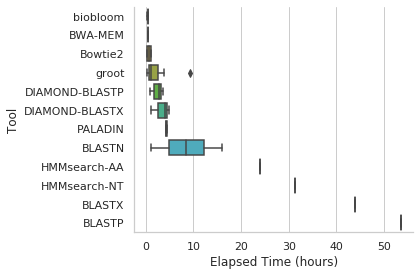

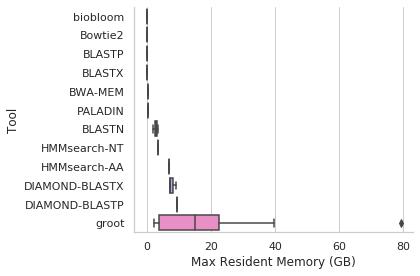

In [25]:
processing_order = timing.groupby('tool')['hours'].describe()['50%'].sort_values()
memory_order = timing.groupby('tool')['gb'].describe()['50%'].sort_values()

sns.boxplot(data = timing.sort_values('hours'), y='tool', x='hours', order=processing_order.index)
sns.despine()
plt.xlabel('Elapsed Time (hours)')
plt.ylabel('Tool')
plt.tight_layout()
plt.savefig('figures/draft_figures/time.png', dpi=300)
plt.show()

sns.boxplot(data = timing.sort_values('gb'), y='tool', x='gb', order=memory_order.index)
sns.despine()
plt.xlabel('Max Resident Memory (GB)')
plt.ylabel('Tool')
plt.tight_layout()
plt.savefig('figures/draft_figures/memory.png', dpi=300)